In [77]:
import json
import numpy as np
from math import log
import pandas as pd
import os
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
import glob
from lifelines import CoxPHFitter
import warnings

import seaborn as sns
warnings.filterwarnings("ignore")

# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)


In [78]:
name = "uni_full_koleo_4096_prototypes"

invasive_path = os.path.join(config['retrained_benchmark_folder2'], 
                                  "invasive_cancer_clustering",
                                   "kmeans")

metadata = pd.read_excel("/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/ST_TNBC_metadata.xlsx")
metadata['patient_id'] = metadata['ST_TNBC_ID'].apply(lambda x: f"TNBC{x}")  # Adjust column name if needed

In [146]:
patients_low_counts = []
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                              config['retrained_model_list2_type']],
                              [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):
    
  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
  
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
  
  for name in names:
    print(f"Processing model: {name}")
    n_clusters = opti_clusters.loc[name, 'n_clusters']

    filename = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results,
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]

    df = pd.read_csv(filename, index_col=0)
    df['patient_id'] = df.index.str.split('_').str[0]
    df_counts = df['patient_id'].value_counts()
    
    patients_low_counts.append(df['patient_id'].value_counts()[df['patient_id'].value_counts() < 100].index.tolist())


Processing model: uni
Processing model: uni_explora_kde_4096_prototypes
Processing model: uni_explora_kde_16384_prototypes
Processing model: uni_explora_kde_65536_prototypes
Processing model: uni_explora_koleo_4096_prototypes
Processing model: uni_explora_koleo_16384_prototypes
Processing model: uni_explora_koleo_65536_prototypes
Processing model: uni
Processing model: uni_full_kde_4096_prototypes
Processing model: uni_full_kde_16384_prototypes
Processing model: uni_full_kde_65536_prototypes
Processing model: uni_full_koleo_4096_prototypes
Processing model: uni_full_koleo_16384_prototypes
Processing model: uni_full_koleo_65536_prototypes


In [147]:
# Flatten list of lists
patients_low_counts_flat = [p for sub in patients_low_counts for p in sub]

# Optional: unique patient IDs while preserving order
patients_low_counts_unique = list(dict.fromkeys(patients_low_counts_flat))

# Quick check
print(len(patients_low_counts_unique), "patients with low spot counts (<100 patches) will be excluded.")

24 patients with low spot counts (<100 patches) will be excluded.


In [148]:
cph_dict = {}
cox_dfs = {}

for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                              config['retrained_model_list2_type']],
                              [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):
    
  path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans")
  
  opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
  
  for name in names:
    print(f"Processing model: {name}")
    n_clusters = opti_clusters.loc[name, 'n_clusters']

    filename = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results,
                                        name, 
                                        f"invasive_labels_{n_clusters}_clusters_umap_min_dist*"))[0]

    df = pd.read_csv(filename, index_col=0)
    df['patient_id'] = df.index.str.split('_').str[0]
    df = df[~df['patient_id'].isin(patients_low_counts_unique)]
    # Extract patient IDs from the spot names in df
    # Assuming spot names have format like "TNBC78_1x2" where "TNBC78" is the patient ID
    df['patient_id'] = df.index.str.split('_').str[0]

    # Count spots per cluster per patient
    cluster_counts = df.groupby(['patient_id', 'predicted_label']).size().reset_index(name='count')

    # Calculate total spots per patient
    total_spots = df.groupby('patient_id').size().reset_index(name='total')

    # Merge and calculate percentages
    cluster_composition = cluster_counts.merge(total_spots, on='patient_id')
    cluster_composition['percentage'] = (cluster_composition['count'] / cluster_composition['total']) * 100

    # Pivot to get one row per patient with columns for each cluster
    cluster_composition_wide = cluster_composition.pivot(
        index='patient_id', 
        columns='predicted_label', 
        values='percentage'
    ).fillna(0)

    # Rename columns to be more descriptive
    cluster_composition_wide.columns = [f'cluster_{col}_pct' for col in cluster_composition_wide.columns]
    # Merge the dataframes
    patient_data = cluster_composition_wide.merge(
        metadata[['patient_id', 'OS_years', 'OS-event', 'Age_at_diagnosis']], 
        left_index=True, 
        right_on='patient_id',
        how='inner'
    )
    patient_data.set_index('patient_id', inplace=True)
    
    cluster_cols = [col for col in patient_data.columns if col.startswith('cluster_')]
    
    df = patient_data.dropna()
    

    # Handle zeros and normalize
    df[cluster_cols] = df[cluster_cols].clip(lower=1e-6)
    df[cluster_cols] = df[cluster_cols].div(df[cluster_cols].sum(axis=1), axis=0)

    # CLR transform
    log_vals = np.log(df[cluster_cols])
    clr_vals = log_vals.sub(log_vals.mean(axis=1), axis=0)
    clr_df = clr_vals.add_suffix("_clr")

    # Combine with survival data
    cox_df = pd.concat([df[["OS_years","OS-event"]], clr_df], axis=1)
    
    
    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(cox_df, duration_col="OS_years", event_col="OS-event")
    
    cph_dict[name] = cph
    
    cox_dfs[name] = cox_df


Processing model: uni
Processing model: uni_explora_kde_4096_prototypes
Processing model: uni_explora_kde_16384_prototypes
Processing model: uni_explora_kde_65536_prototypes
Processing model: uni_explora_koleo_4096_prototypes
Processing model: uni_explora_koleo_16384_prototypes
Processing model: uni_explora_koleo_65536_prototypes
Processing model: uni
Processing model: uni_full_kde_4096_prototypes
Processing model: uni_full_kde_16384_prototypes
Processing model: uni_full_kde_65536_prototypes
Processing model: uni_full_koleo_4096_prototypes
Processing model: uni_full_koleo_16384_prototypes
Processing model: uni_full_koleo_65536_prototypes


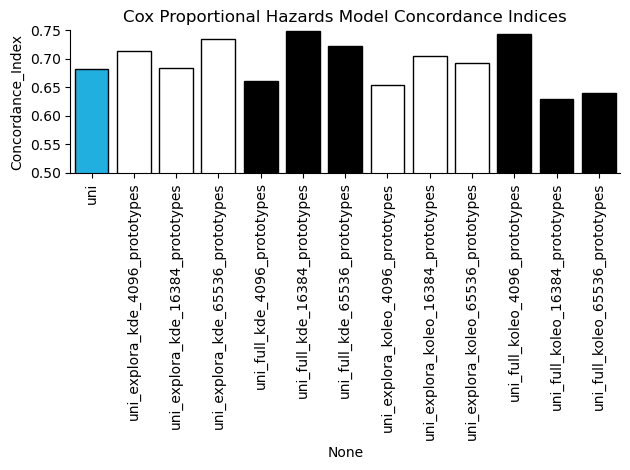

In [149]:
CIs = {name: cph_dict[name].concordance_index_ for name in cph_dict}
df_CIs = pd.DataFrame.from_dict(CIs, orient='index', columns=['Concordance_Index'])

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")
        
df_CIs = df_CIs.loc[sorted_retrained_models]


sns.barplot(x=df_CIs.index, y='Concordance_Index', data=df_CIs, palette=palette, edgecolor='black')
plt.xticks(rotation=90)
plt.ylim(0.5, 0.75)
plt.title("Cox Proportional Hazards Model Concordance Indices")
plt.tight_layout()
sns.despine()


In [150]:
df_CIs

,Concordance_Index
uni,0.681538
uni_explora_kde_4096_prototypes,0.713846
uni_explora_kde_16384_prototypes,0.684615
uni_explora_kde_65536_prototypes,0.735385
uni_full_kde_4096_prototypes,0.660769
uni_full_kde_16384_prototypes,0.749231
uni_full_kde_65536_prototypes,0.723077
uni_explora_koleo_4096_prototypes,0.653846
uni_explora_koleo_16384_prototypes,0.704615
uni_explora_koleo_65536_prototypes,0.692308


([0, 1], [Text(0, 0, 'uni'), Text(1, 0, 'uni_full_koleo_4096_prototypes')])

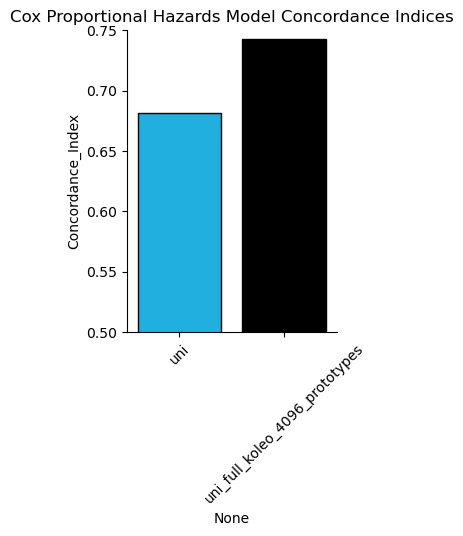

In [151]:
plt.figure(figsize=(3,6))
sns.barplot(x=df_CIs.loc[["uni",
                          "uni_full_koleo_4096_prototypes"]].index, 
            y='Concordance_Index',
            data=df_CIs.loc[["uni",
                             "uni_full_koleo_4096_prototypes"]], 
            palette=["deepskyblue", "black"], 
            edgecolor='black')
plt.xticks(rotation=90)
plt.ylim(0.5, 0.75)
plt.title("Cox Proportional Hazards Model Concordance Indices")
plt.tight_layout()
sns.despine()
plt.xticks(rotation=45)

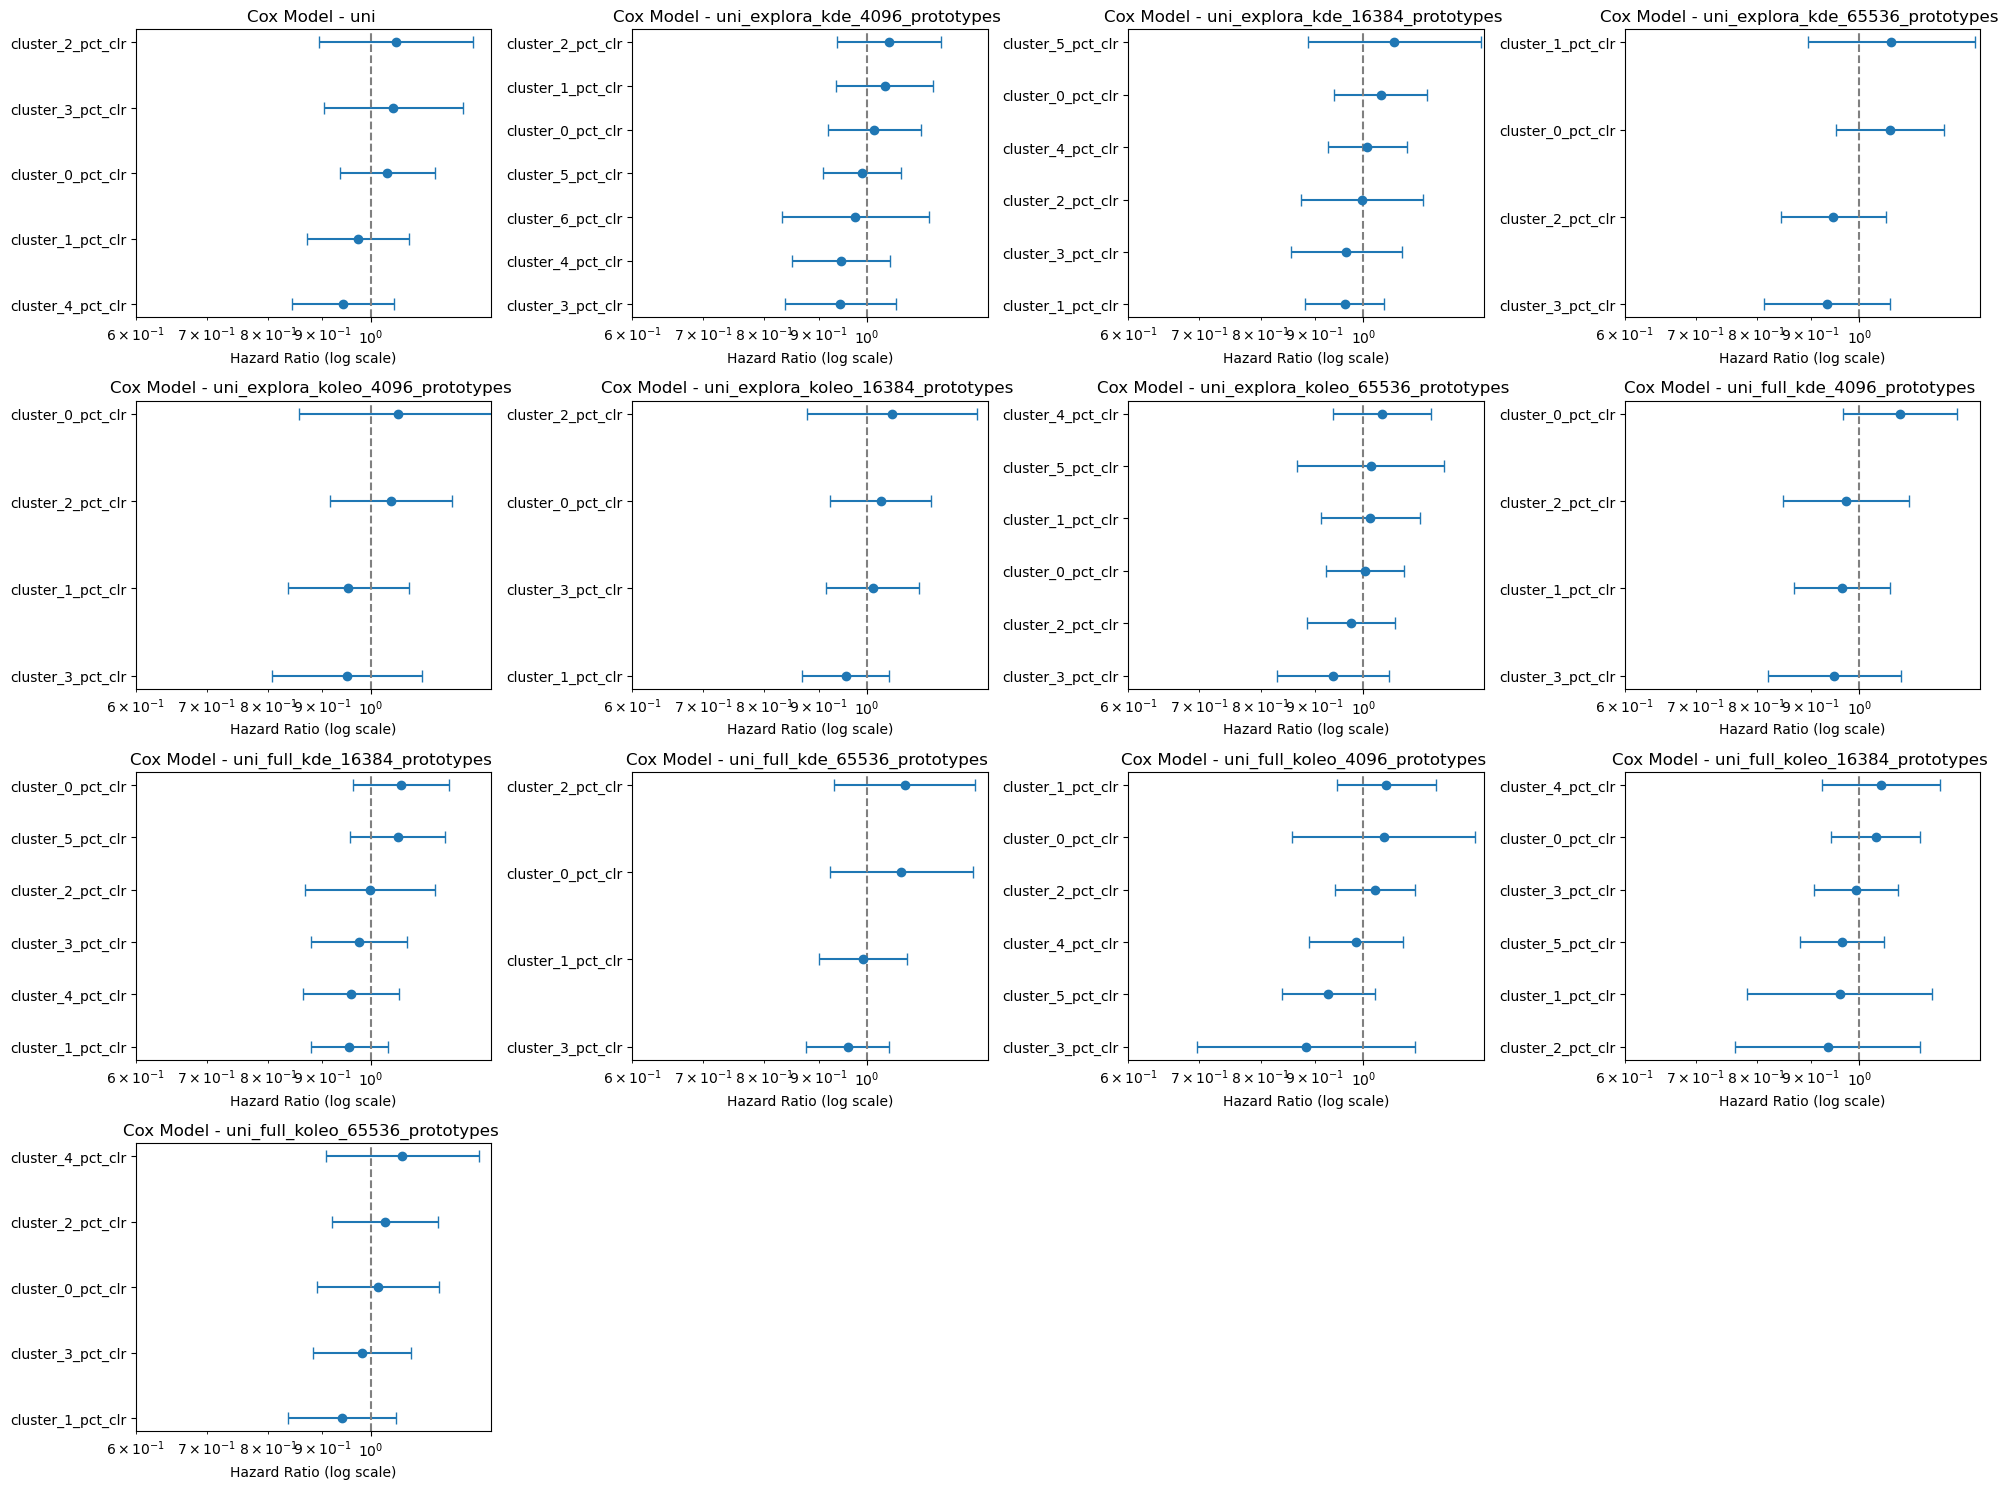

In [153]:
import numpy as np
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(20, 15))
for name, cph in cph_dict.items():
    
    i += 1
    plt.subplot(4, int(np.ceil(len(cph_dict)/4)), i)
    summary = cph.summary.copy()
    summary = summary.sort_values("exp(coef)")  # Order visually

    hr = summary["exp(coef)"]
    ci_lower = summary["exp(coef) lower 95%"]
    ci_upper = summary["exp(coef) upper 95%"]
    labels = summary.index

    
    plt.errorbar(hr, labels, 
                xerr=[hr-ci_lower, ci_upper-hr], 
                fmt='o', capsize=4)

    plt.axvline(1, color='grey', linestyle='--')
    plt.xlabel("Hazard Ratio (log scale)")
    plt.xscale("log")
    plt.xlim(0.6, 1.3)
    plt.title(f"Cox Model - {name} ")
    plt.tight_layout()


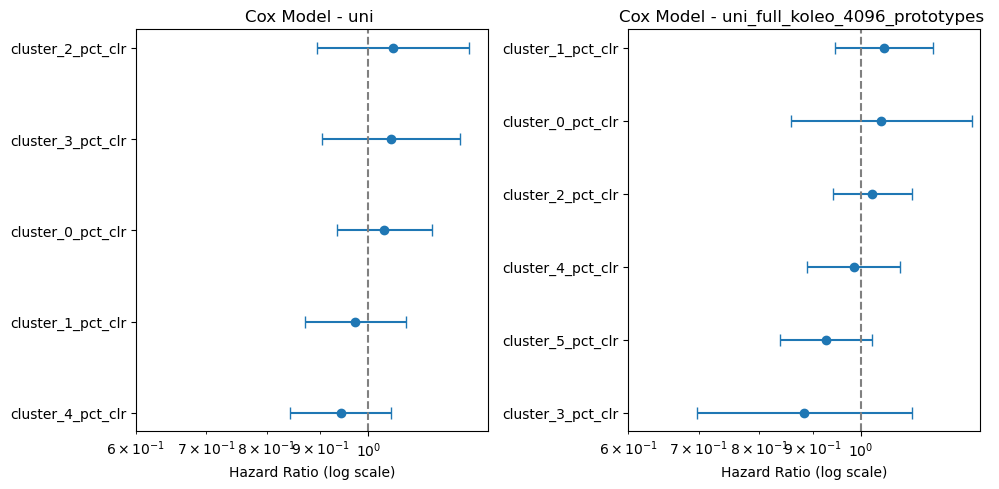

In [157]:
import numpy as np
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10, 5))
for name, cph in cph_dict.items():
    if name not in ["uni",
                    "uni_full_koleo_4096_prototypes"]:
        continue
    i += 1
    plt.subplot(1, 2, i)
    summary = cph.summary.copy()
    summary = summary.sort_values("exp(coef)")  # Order visually

    hr = summary["exp(coef)"]
    ci_lower = summary["exp(coef) lower 95%"]
    ci_upper = summary["exp(coef) upper 95%"]
    labels = summary.index

    
    plt.errorbar(hr, labels, 
                xerr=[hr-ci_lower, ci_upper-hr], 
                fmt='o', capsize=4)

    plt.axvline(1, color='grey', linestyle='--')
    plt.xlabel("Hazard Ratio (log scale)")
    plt.xscale("log")
    plt.xlim(0.6, 1.3)
    plt.title(f"Cox Model - {name} ")
    plt.tight_layout()

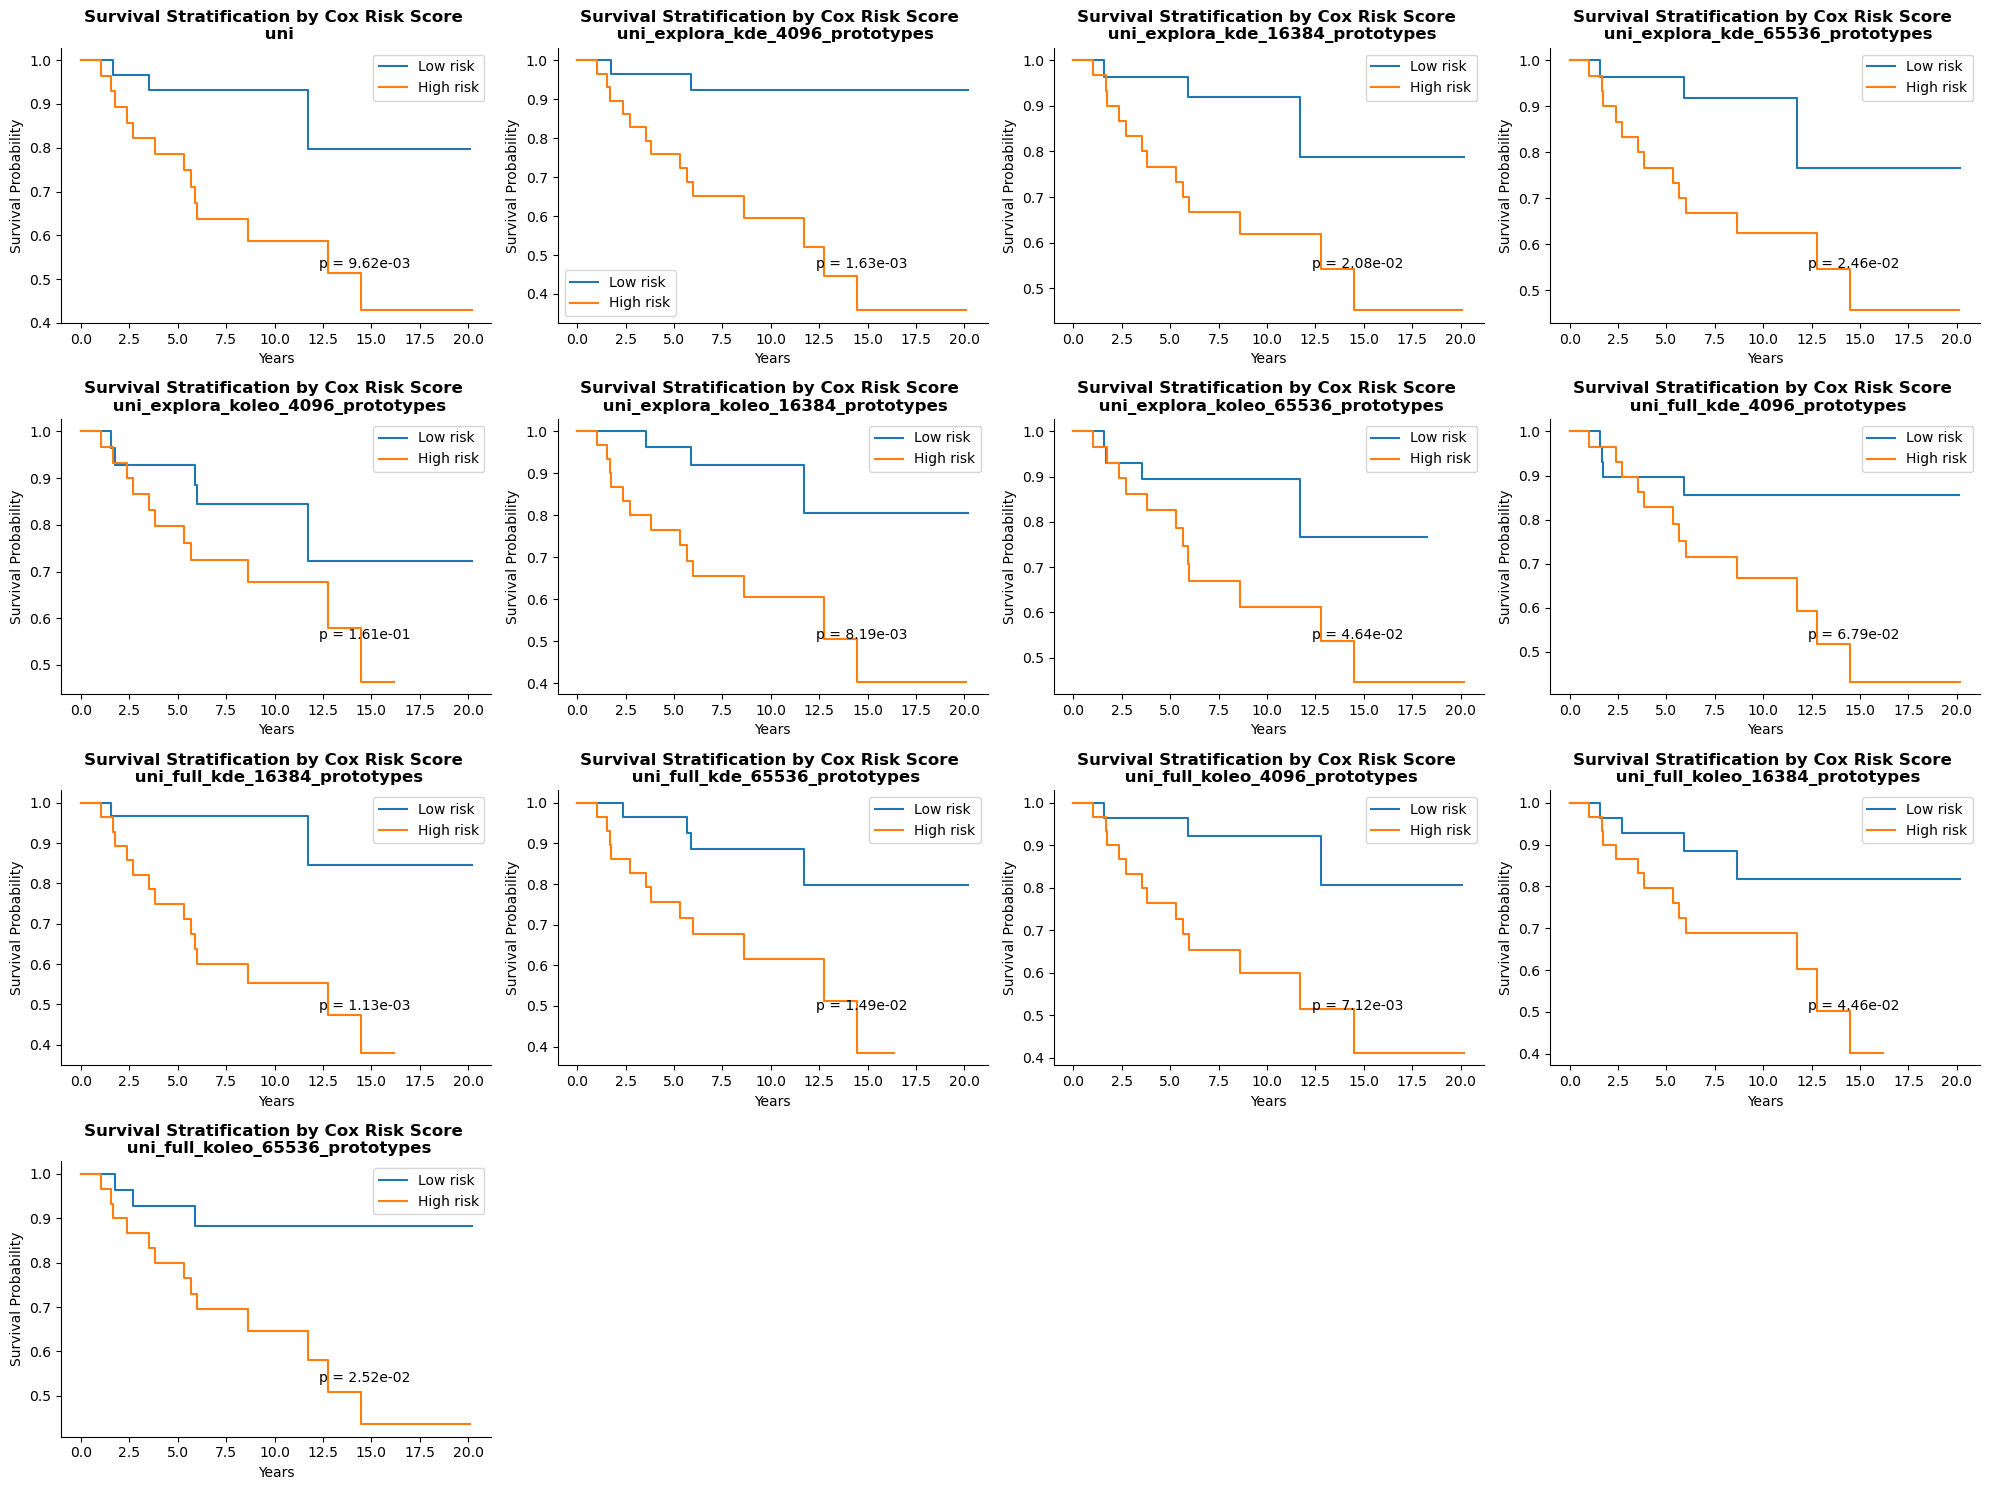

In [154]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns
# Compute risk score (linear predictor)
i = 0
plt.figure(figsize=(20, 15))
for name, cph in cph_dict.items():
    
    i += 1
    plt.subplot(4, int(np.ceil(len(cph_dict)/4)), i)
    cox_dfs[name]["risk_score"] = cph.predict_partial_hazard(cox_dfs[name])

    # Stratify into High vs Low using median
    median = cox_dfs[name]["risk_score"].median()
    cox_dfs[name]["risk_group"] = np.where(cox_dfs[name]["risk_score"] > median, "High risk", "Low risk")

    # Fit KMF curves
    km = KaplanMeierFitter()

    for group in ["Low risk", "High risk"]:
        mask = cox_dfs[name]["risk_group"] == group
        km.fit(cox_dfs[name].loc[mask, "OS_years"],
            cox_dfs[name].loc[mask, "OS-event"],
            label=group)
        km.plot(ci_show=False)

    plt.title(f"Survival Stratification by Cox Risk Score \n uni_full_koleo_4096_prototypes", weight='bold')
    plt.xlabel("Years")
    plt.ylabel("Survival Probability")

    # Log-rank test
    res = logrank_test(
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS-event"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS-event"]
    )
    plt.text(0.6, 0.2, f"p = {res.p_value:.2e}",
            transform=plt.gca().transAxes)
    plt.title(f"Survival Stratification by Cox Risk Score \n {name}", weight='bold')
    plt.tight_layout()

    sns.despine()

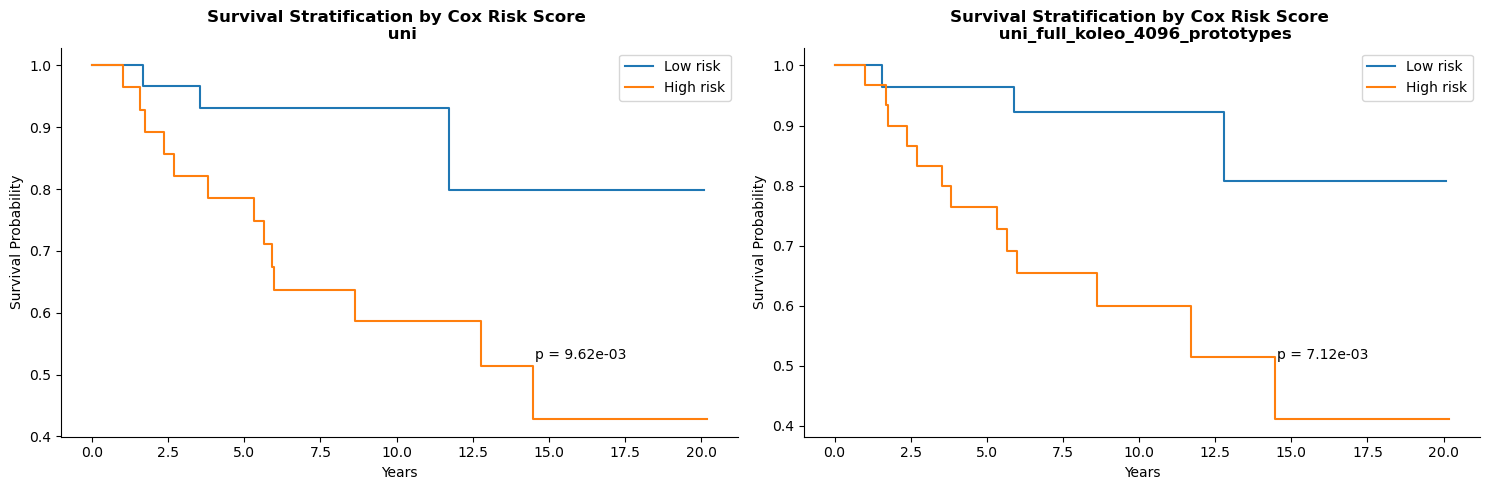

In [165]:
i = 0
plt.figure(figsize=(15, 5))
for name, cph in cph_dict.items():
    if name not in ["uni",
                    "uni_full_koleo_4096_prototypes"]:
        continue
    i += 1
    plt.subplot(1, 2, i)
    cox_dfs[name]["risk_score"] = cph.predict_partial_hazard(cox_dfs[name])

    # Stratify into High vs Low using median
    median = cox_dfs[name]["risk_score"].median()
    cox_dfs[name]["risk_group"] = np.where(cox_dfs[name]["risk_score"] > median, "High risk", "Low risk")

    # Fit KMF curves
    km = KaplanMeierFitter()

    for group in ["Low risk", "High risk"]:
        mask = cox_dfs[name]["risk_group"] == group
        km.fit(cox_dfs[name].loc[mask, "OS_years"],
            cox_dfs[name].loc[mask, "OS-event"],
            label=group)
        km.plot(ci_show=False)

    plt.title(f"Survival Stratification by Cox Risk Score \n uni_full_koleo_4096_prototypes", weight='bold')
    plt.xlabel("Years")
    plt.ylabel("Survival Probability")

    # Log-rank test
    res = logrank_test(
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS_years"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="Low risk", "OS-event"],
        cox_dfs[name].loc[cox_dfs[name]["risk_group"]=="High risk", "OS-event"]
    )
    plt.text(0.7, 0.2, f"p = {res.p_value:.2e}",
            transform=plt.gca().transAxes)
    plt.title(f"Survival Stratification by Cox Risk Score \n {name}", weight='bold')
    plt.tight_layout()

    sns.despine()

In [166]:
## Look at extremes slides

cox_df = cox_dfs["uni_full_koleo_4096_prototypes"]

In [167]:
len(cox_df)

60

In [172]:
cox_df.sort_values("cluster_1_pct_clr", ascending=False)

,OS_years,OS-event,cluster_0_pct_clr,cluster_1_pct_clr,cluster_2_pct_clr,cluster_3_pct_clr,cluster_4_pct_clr,cluster_5_pct_clr,risk_score,risk_group
patient_id,,,,,,,,,,
TNBC61,6.443836,0.0,-8.303755,6.645995,-8.303755,9.884674,-8.303755,8.380596,0.166638,Low risk
TNBC4,5.989041,1.0,9.918900,6.506653,-8.276442,8.403773,-8.276442,-8.276442,1.593236,High risk
TNBC69,7.101370,0.0,3.160192,5.965880,-10.984892,6.711135,-10.984892,6.132577,0.461066,Low risk
TNBC39,6.304110,0.0,5.015455,5.952799,-11.189265,6.581408,-11.189265,4.828869,0.560592,Low risk
TNBC72,7.065753,0.0,1.532068,5.446089,-12.393258,5.164377,-0.770517,1.021242,0.614109,Low risk
TNBC85,6.309589,0.0,0.840211,4.553783,-13.031870,4.635700,0.147063,2.855114,0.512944,Low risk
TNBC15,8.879452,0.0,2.075200,4.195464,-12.976271,4.968654,-0.815171,2.552124,0.531273,Low risk
TNBC35,6.413699,0.0,5.120393,3.886308,-12.979232,2.120125,0.233056,1.619350,0.902396,Low risk
TNBC9,18.257534,0.0,4.153129,3.875497,-12.888862,4.933287,-0.036526,-0.036526,0.694477,Low risk


In [176]:
metadata[["patient_id", "OS-event", "OS_years"]].set_index("patient_id").loc["TNBC61"]

OS-event    0.000000
OS_years    6.443836
Name: TNBC61, dtype: float64